# Common ML pipeline using CNNs

In this tutorial we're going to see a common ML/deep learning pipeline.
It consists, informally, from the following steps:
1. preprocessing and visualizing/understanding your data
2. choosing a good model (off-the-shelf or custom?) and a loss function
3. training and monitoring the model

And it involves **a lot of iteration.**

#todo: docs, GitHub, arxiv are your friends

---

The problem we're going to "solve" today is to train a model to **classify** **ants** and **bees**.

<img src="img/ant.jpg" alt="an ant image" align="left" style="width: 350px;"/>
<img src="img/bee.jpg" alt="a bee image" align="center" style="width: 350px;"/>

step 1: Import libraries
---------

In [53]:
# Python's native libraries
import time
import os
import copy
from collections import defaultdict

# deep learning/vision libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv  # OpenCV

# numeric and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Libraries are your best friends
-----

If you know how to use these you can create awesome things even if you're not an expert in mathematics, statistics, ML, deep learning, etc.

### NumPy - used literally everywhere
Either explicitly like OpenCV uses it internally or implicitly with PyTorch, TensorFlow
<img src="img/numpy.png" alt="numpy" style="width: 350px;"/>

### OpenCV - the go-to computer vision library
Image processing (resize, crop, etc.), even some basic ML/deep learning algorithms for imagery
<img src="img/opencv.png" alt="opencv" style="width: 200px;"/>

### Scikit-learn - used for more classic ML algorithms 
(linear regression, PCA, Gaussian Mixture Models, SVM, etc.)
<img src="img/scikit_learn.png" alt="scikit learn" style="width: 350px;"/>

### PyTorch - used for deep learning (neural networks)
The most popular framework for deep learning aside from *TensorFlow*
<img src="img/pytorch.jpeg" alt="pytorch" style="width: 350px;"/>

step 2: Prepare the data
---------

We have about 120 training and 75 validation images for each class (ants & bees). Usually, this is a very small dataset to generalize upon, if trained from scratch. 
Since we are using transfer learning, we should be able to generalize reasonably well.

---

**Download the data** from here `<https://download.pytorch.org/tutorial/hymenoptera_data.zip>` and extract it to the current directory.

_Note:_ this dataset is a very small subset of the famous ImageNet dataset.

In [85]:
# We use data augmentation and normalization for training and only normalization for validation
# Data augmentation helps your model to better generalize to unseen images

#
# There are broadly 2 types of augmentations for images: photometric and geometric augmentations
#
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406])  # iterate over ImageNet's images and calculate these statistics
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225]) 

# These will be executed over every training/val image (handled by PyTorch's dataloader)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN_1, IMAGENET_STD_1)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN_1, IMAGENET_STD_1)
    ]),
}

data_dir = 'hymenoptera_data/'

# basic error checking to check whether you correctly unzipped the dataset into the working directory
assert os.path.exists(data_dir), f'Could not find {data_dir} in working directory {os.getcwd()}n'
dirs_exist = [os.path.exists(os.path.join(data_dir, x)) for x in ['train', 'val']]
assert all(dirs_exist), f'Could not find train/val dirs check if you have train and val directly under {data_dir}.'

# ImageFolder is a PyTorch class - it expects <class1>, <class2>, ... under the root path you give it
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Dataloaders conviniently wraps up batch size and other details into a single object 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

# cuda:0 is the 1st GPU on your system if you had more than 1 you could use the 2nd by setting cuda:1, etc.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}, (cuda:0 is prefered over CPU).")  

Using device cuda:0, (cuda:0 is prefered over CPU).


step 3: Understand your data (visualizations)
---------

Important terms:
**Ground Truth (GT)** - correct labels

Created either:
1. Purely by humans - somebody sits down, given instructions, follows those instructions and labels the data (boring)
2. Semi-automatic - a part of the labels are produced by some algorithms, humans just slightly modify those
3. Fully-automatic - some kind of autonomous pipeline that creates the GT labels

_Note: if we have synthetic data (SX) than we're always getting GT "for free" i.e. the 3rd option above._

Extremely laborous semantic segmentation labeling:

<img src="img/gt.png" alt="ground truth for semantic segmentation" align="center" style="width: 450px;"/>


In our case somebody had to go through images and click either bee or ant - it's error prone so usually every image is passed to multiple annotators and usually by majority-voting we get the correct label (with high probability).


Training dataset size: 244 images, Validation dataset size: 153 images
Classes in our training/val datasets: ['ants', 'bees', 'majmuh']
Shape of batch of images: torch.Size([4, 3, 224, 224])
Image grid shape=torch.Size([3, 228, 906])


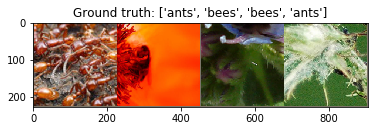

In [86]:
def imshow_tensor(tensor, title=None):
    """Imshow for Tensor."""
    # convert PyTorch Tensor to numpy and change from channel first to channel last (2 common image layouts HWC & CHW)
    # similar to RBG<->BGR confusion...
    img = tensor.numpy().transpose((1, 2, 0))
    img = IMAGENET_STD_1 * img + IMAGENET_MEAN_1 # denormalize
    img = np.clip(img, 0, 1)  # todo: print(np.min(img), np.max(img)) try and see what the range is before and after clip
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f'Training dataset size: {dataset_sizes["train"]} images, Validation dataset size: {dataset_sizes["val"]} images')

# todo: (understanding how ImageFolder works) add dummy class under train/ and run again
class_names = image_datasets['train'].classes
print(f"Classes in our training/val datasets: {class_names}")

img_batch, classes = next(iter(dataloaders['train'])) # Get a batch of training data
print(f'Shape of batch of images: {img_batch.shape}')

image_grid = torchvision.utils.make_grid(img_batch) # Make an image grid from batch
print(f'Image grid shape={image_grid.shape}')  # Knowing shapes of your tensors is helpful for debugging!

# Ground truth is the correct label of the image - contrast that with predicted label that the model outputs
imshow_tensor(image_grid, title='Ground truth: ' + str([class_names[x] for x in classes]))

# step 4: Define the core util functions
------------------

In [49]:
def train_model(model, criterion, optimizer, num_epochs=25):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = float(running_corrects) / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            metrics[phase+"_loss"].append(epoch_loss)
            metrics[phase+"_acc"].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

Visualize model predictions
---------



In [50]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
# Count how many trainable weights the model has <- just for having a feeling for how big the model is
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Off-the-shelf vs custom models
----------------------

There are many popular models in torchvision - like **ResNets**, **VGG**, **MobileNets**, etc.

But sometimes you may wish to create your own model - because it's SOTA and hasn't yet been integrated into PyTorch.

![title](img/resnet_vgg.png)

step 5: Fine-tuning off-the-shelf models (transfer learning)
----------------------------------

Here, we need to freeze all of the layers of the network except the final layer. 

We need to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

Loss functions are really important! Our model is as good as our loss function.
If it correlates perfectly with the performance we want our model to have, super! If not well we'll have to have some kind of visual inspections as the curves themselves won't cut it.

We'll be using this loss function (**cross entropy**) for classification:
![cross entropy loss](img/cross_entropy.png)

**Arxiv and GitHub are your good friends!**

In [88]:
# todo: open https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py to understand why fc
# todo: open https://arxiv.org/pdf/1512.03385.pdf <- originally used SGD we'll stick with Adam, why?

# todo: add model images and loss

# todo: first try off-the-shelf models without any training than with fine-tuning and than custom

SUPPORTED_MODELS = ['resnet18', 'vgg16', 'mnetv2']
model_name = SUPPORTED_MODELS[1]

if model_name == SUPPORTED_MODELS[0]:
    model = torchvision.models.resnet18(pretrained=True)
elif model_name == SUPPORTED_MODELS[1]:
    model = torchvision.models.vgg16(pretrained=True)
elif model_name == SUPPORTED_MODELS[2]:
    model = torchvision.models.mobilenet_v2(pretrained=True)
else:
    raise Exception(f'Model {model_name} not supported yet.')

print(f"Using {model_name}, number of trainable params before freezing {count_parameters(model)}")
    
# Freeze parameters - making them non-trainable
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# todo: use PyTorch's GitHub to figure out how to modify the model output layers
finetuned_model = copy.deepcopy(model)
if model_name == SUPPORTED_MODELS[0]:
    num_ftrs = finetuned_model.fc.in_features
    finetuned_model.fc = nn.Linear(num_ftrs, 2)
elif model_name == SUPPORTED_MODELS[1]:
    # todo: erase this before the workshop I expect them to be able to figure this out
    # print(len(model.classifier), type(model.classifier), type(model.classifier[6]), model.classifier[6].in_features)
    num_ftrs = finetuned_model.classifier[6].in_features
    finetuned_model.classifier[6] = nn.Linear(num_ftrs, 2)
elif model_name == SUPPORTED_MODELS[2]:
    num_ftrs = finetuned_model.classifier[1].in_features
    finetuned_model.classifier[1] = nn.Linear(num_ftrs, 2)

print(f"Num of params after freezing: {count_parameters(finetuned_model)}")

model = model.to(device)
finetuned_model = finetuned_model.to(device)  # place the model onto the GPU (you hopefully have one)

# loss function - this pretty much defines the model
criterion = nn.CrossEntropyLoss()

# We optimize only the trainable params
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()))

Using vgg16, number of trainable params before freezing 138357544
Num of params after freezing: 8194


Predict directly with off-the-shelf models
-----

IndexError: list index out of range

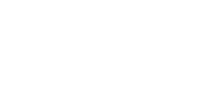

In [68]:
visualize_model(model)  # This won't work, why? Anybody?

Predict after fine-tuning procedure
-----

Epoch 0/24
----------
train Loss: 0.6074 Acc: 0.6762
val Loss: 0.5644 Acc: 0.6863

Epoch 1/24
----------
train Loss: 0.4581 Acc: 0.7828
val Loss: 0.2052 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3967 Acc: 0.8156
val Loss: 0.1808 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4377 Acc: 0.8074
val Loss: 0.1673 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.3691 Acc: 0.8320
val Loss: 0.1601 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4800 Acc: 0.7705
val Loss: 0.2218 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3826 Acc: 0.8156
val Loss: 0.1440 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3415 Acc: 0.8566
val Loss: 0.1317 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3976 Acc: 0.8402
val Loss: 0.1384 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4603 Acc: 0.7910
val Loss: 0.1372 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3029 Acc: 0.8648
val Loss: 0.2483 Acc: 0.8758

Epoch 11/24
----------
train Loss: 0.3026 Acc: 0.8730
val Loss: 0.1198 Acc: 0.9542

Ep

<Figure size 432x288 with 0 Axes>

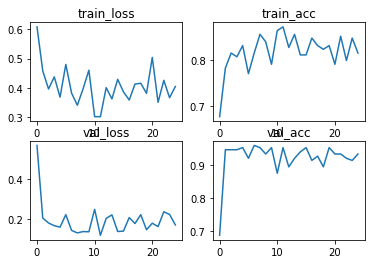

In [75]:
def display_metrics_charts(metrics):
    plt.subplots_adjust(wspace=1, hspace=1)
    fig, ax = plt.subplots(nrows=2, ncols=2)
    keys = list(metrics.keys())
    cnt = 0
    for row in ax:
        for col in row:
            col.set_title(keys[cnt])
            col.plot(metrics[keys[cnt]])
            cnt += 1

finetuned_model, metrics = train_model(finetuned_model, criterion, optimizer, num_epochs=25)

display_metrics_charts(metrics)


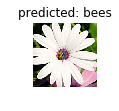

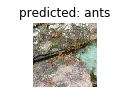

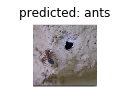

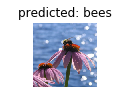

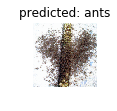

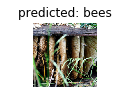

In [77]:
visualize_model(finetuned_model)  # todo: make a grid visualization and bigger images

step 6: Using a custom (CNN) model
-----

Generic off-the-shelf models are good. But in industry when you want to create the best product for your users,
you want to use custom models which were designed for that very specific task! (and not generic image classification models)

number of params in model 109986
Epoch 0/124
----------
train Loss: 0.6933 Acc: 0.4959
val Loss: 0.6936 Acc: 0.4771

Epoch 1/124
----------
train Loss: 0.6926 Acc: 0.5246
val Loss: 0.6936 Acc: 0.4771

Epoch 2/124
----------
train Loss: 0.6929 Acc: 0.4959
val Loss: 0.6936 Acc: 0.4771

Epoch 3/124
----------
train Loss: 0.6932 Acc: 0.4959
val Loss: 0.6936 Acc: 0.4771

Epoch 4/124
----------
train Loss: 0.6933 Acc: 0.5205
val Loss: 0.6936 Acc: 0.4771

Epoch 5/124
----------
train Loss: 0.6933 Acc: 0.4795
val Loss: 0.6936 Acc: 0.4771

Epoch 6/124
----------
train Loss: 0.6931 Acc: 0.4959
val Loss: 0.6936 Acc: 0.4771

Epoch 7/124
----------
train Loss: 0.6932 Acc: 0.5082
val Loss: 0.6936 Acc: 0.4771

Epoch 8/124
----------
train Loss: 0.6930 Acc: 0.5082
val Loss: 0.6936 Acc: 0.4771

Epoch 9/124
----------
train Loss: 0.6932 Acc: 0.5164
val Loss: 0.6936 Acc: 0.4771

Epoch 10/124
----------
train Loss: 0.6933 Acc: 0.5041
val Loss: 0.6936 Acc: 0.4771

Epoch 11/124
----------
train Loss: 0.6933

train Loss: 0.6938 Acc: 0.4836
val Loss: 0.6936 Acc: 0.4771

Epoch 97/124
----------
train Loss: 0.6931 Acc: 0.4877
val Loss: 0.6936 Acc: 0.4771

Epoch 98/124
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6936 Acc: 0.4771

Epoch 99/124
----------
train Loss: 0.6936 Acc: 0.5246
val Loss: 0.6936 Acc: 0.4771

Epoch 100/124
----------
train Loss: 0.6932 Acc: 0.5000
val Loss: 0.6936 Acc: 0.4771

Epoch 101/124
----------
train Loss: 0.6929 Acc: 0.5164
val Loss: 0.6936 Acc: 0.4771

Epoch 102/124
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6936 Acc: 0.4771

Epoch 103/124
----------
train Loss: 0.6931 Acc: 0.5123
val Loss: 0.6936 Acc: 0.4771

Epoch 104/124
----------
train Loss: 0.6927 Acc: 0.5410
val Loss: 0.6936 Acc: 0.4771

Epoch 105/124
----------
train Loss: 0.6935 Acc: 0.4877
val Loss: 0.6936 Acc: 0.4771

Epoch 106/124
----------
train Loss: 0.6935 Acc: 0.4877
val Loss: 0.6936 Acc: 0.4771

Epoch 107/124
----------
train Loss: 0.6934 Acc: 0.4959
val Loss: 0.6936 Acc: 0.47

<Figure size 432x288 with 0 Axes>

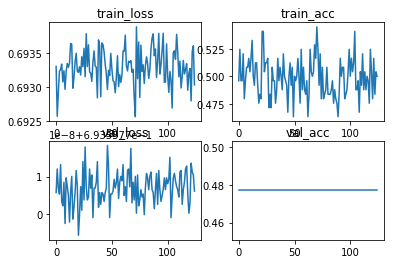

In [89]:
class CustomCNN(nn.Module):

    def __init__(self):
        super().__init__()
        num_of_channels = [3, 16, 32, 64, 128]
        kernel_sizes = [3, 3, 3, 3]
        stride_sizes = [2, 2, 2, 2]
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = nn.Conv2d(num_of_channels[0], num_of_channels[1], kernel_size=kernel_sizes[0], stride=stride_sizes[0])
        self.conv2 = nn.Conv2d(num_of_channels[1], num_of_channels[2], kernel_size=kernel_sizes[1], stride=stride_sizes[1])
        self.conv3 = nn.Conv2d(num_of_channels[2], num_of_channels[3], kernel_size=kernel_sizes[2], stride=stride_sizes[2])
        self.conv4 = nn.Conv2d(num_of_channels[3], num_of_channels[4], kernel_size=kernel_sizes[3], stride=stride_sizes[3])
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Linear(num_of_channels[-1] * 7 * 7, 2)
        
    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.relu(self.conv2(y))
        y = self.relu(self.conv3(y))
        y = self.relu(self.conv4(y))
        y = self.avgpool(y)
        y = torch.flatten(y, 1)
        y = self.classifier(y)
        return y
    
custom_cnn = CustomCNN().to(device)

# Count how many trainable weights the model has <- just for having a feeling for how big the model is
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"number of params in model {count_parameters(custom_cnn)}")

# train_loader = dataloaders['train']
# for batch, _ in train_loader:
#     batch = batch.to(device)
#     out = custom_cnn(batch)
#     break

# todo: Why is acc 0.5? Anybody?
model_conv, metrics = train_model(custom_cnn, criterion, optimizer_conv, num_epochs=125)

plt.subplots_adjust(wspace=1, hspace=1)
fig, ax = plt.subplots(nrows=2, ncols=2)
keys = list(metrics.keys())
cnt = 0
for row in ax:
    for col in row:
        col.set_title(keys[cnt])
        col.plot(metrics[keys[cnt]])
        cnt += 1


step 7: Demystyfing CNNs - visualize feature maps
-----

False


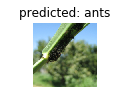

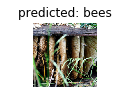

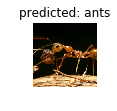

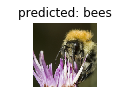

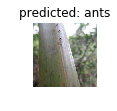

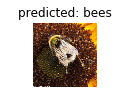

In [80]:
def visualize_model(model, num_images=6):
    was_training = model.training
    print(was_training)
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(finetuned_model)